In [1]:
from datasets import load_dataset

# Directly stream the Hindi-Devanagari split
hindi_stream = load_dataset(
    "ai4bharat/IndicCorpV2",
    "indiccorp_v2",
    streaming=True,
    split="hin_Deva"  
)



c:\Users\91630\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from itertools import islice

samples = list(islice(hindi_stream, 1000000))  


In [3]:
text = samples[0]['text']


In [7]:
import re

def hindi_tokenizer(text):
    url_pattern = r'https?://[^\s]+|www\.[^\s]+'
    email_pattern = r'\b[\w\.-]+@[\w\.-]+\.\w{2,4}\b'

    # Save and replace URLs and emails
    urls = re.findall(url_pattern, text)
    text = re.sub(url_pattern, '<URL>', text)

    emails = re.findall(email_pattern, text)
    text = re.sub(email_pattern, '<EMAIL>', text)

    tokens = []
    for token in text.split():
        if token == '<URL>':
            tokens.append(urls.pop(0))
        elif token == '<EMAIL>':
            tokens.append(emails.pop(0))
        else:
            split_tokens = re.findall(
                r'[\u0900-\u097F]+|[a-zA-Z0-9]+|[।.,!?;:()\"\'\-]|[^\s]',
                token
            )
            tokens.extend(split_tokens)

    return tokens

def hindi_sentence_tokenizer(text):
    sentence_end_pattern = r'(?<=[।!?\.])\s+'
    sentences = re.split(sentence_end_pattern, text.strip())
    return [s.strip() for s in sentences if s.strip()]

def detokenize(tokens):
    # Rebuild sentence with proper spacing logic
    sentence = ''
    for i, token in enumerate(tokens):
        if i > 0 and not re.match(r'[।.,!?;:)\]\'\"]', token):
            sentence += ' '
        sentence += token
    return sentence.strip()

def hindi_corpus_statistics(text):
    sentences = hindi_sentence_tokenizer(text)
    all_tokens = []
    reconstructed_sentences = []

    for sentence in sentences:
        tokens = hindi_tokenizer(sentence)
        all_tokens.extend(tokens)

        # For checking reformation
        reconstructed = detokenize(tokens)
        reconstructed_sentences.append(reconstructed)

    num_tokens = len(all_tokens)
    unique_tokens = set(all_tokens)
    total_chars = sum(len(token) for token in all_tokens)

    word_tokens = [t for t in all_tokens if re.match(r'^[\u0900-\u097F\w]+$', t)]
    avg_word_length = sum(len(t) for t in word_tokens) / len(word_tokens) if word_tokens else 0
    type_token_ratio = len(unique_tokens) / num_tokens if num_tokens else 0

    return {
        'sentences': sentences,
        'tokens': all_tokens,
        'num_tokens': num_tokens,
        'total_characters': total_chars,
        'average_word_length': round(avg_word_length, 2),
        'type_token_ratio': round(type_token_ratio, 3),
        'reconstructed_sentences': reconstructed_sentences
    }


In [8]:
text = ' '.join(sample['text'] for sample in samples)
stats = hindi_corpus_statistics(text)


with open("tokens.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(stats['tokens']))


with open("sentences.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(stats['sentences']))

with open("resentences.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(stats['reconstructed_sentences']))

print("Number of Tokens:", stats['num_tokens'])
print("Total Characters:", stats['total_characters'])
print("Average Word Length:", stats['average_word_length'])
print("Type-Token Ratio:", stats['type_token_ratio'])

Number of Tokens: 30774011
Total Characters: 118217581
Average Word Length: 4.01
Type-Token Ratio: 0.013


C:\Users\91630\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\91630\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\91630\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\91630\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\91630\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2306 (\N{DEVA

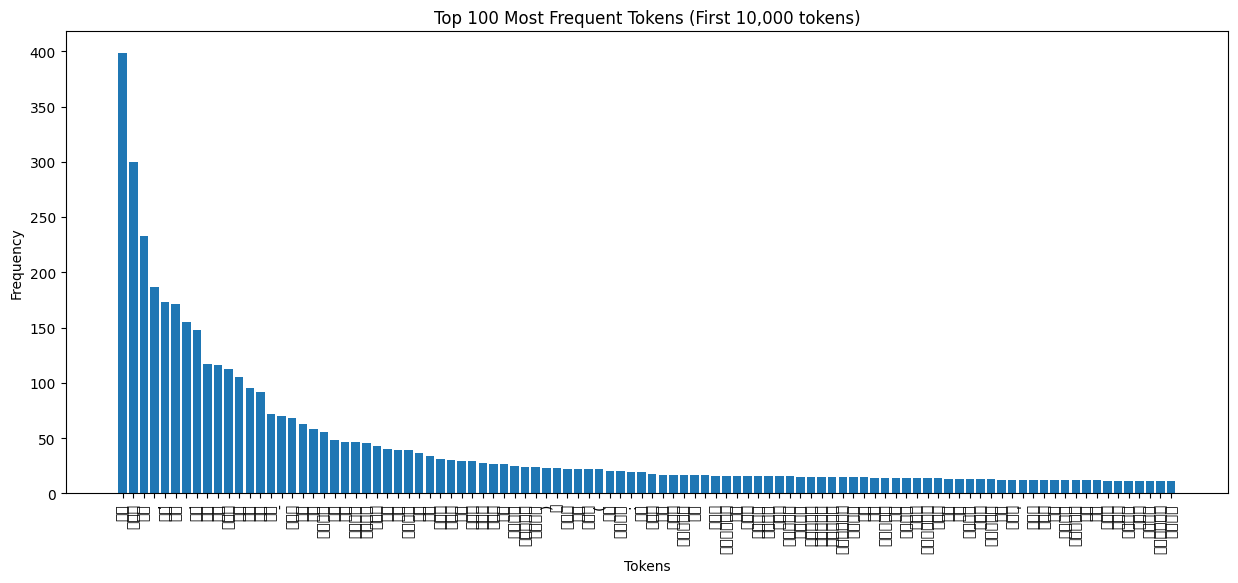

In [1]:
import matplotlib.pyplot as plt

# ---------- STEP 1: READ TOKENS FROM FILE ----------
with open("tokens.txt", "r", encoding="utf-8") as f:
    tokens = [line.strip() for line in f if line.strip()]

# Only first 10,000 tokens
tokens = tokens[:10000]

# ---------- STEP 2: FREQUENCY DISTRIBUTION ----------
freq_dist = {}
for token in tokens:
    freq_dist[token] = freq_dist.get(token, 0) + 1

# ---------- STEP 3: SAVE FREQUENCIES ----------
with open("freq.txt", "w", encoding="utf-8") as f:
    for word, count in sorted(freq_dist.items(), key=lambda x: x[1], reverse=True):
        f.write(f"{word}\t{count}\n")

# ---------- STEP 4: PLOT TOP 100 ----------
sorted_freq = sorted(freq_dist.items(), key=lambda x: x[1], reverse=True)
top_100 = sorted_freq[:100]

if top_100:
    words, counts = zip(*top_100)

    plt.figure(figsize=(15, 6))
    plt.bar(words, counts)
    plt.xticks(rotation=90, fontsize=10)
    plt.title("Top 100 Most Frequent Tokens (First 10,000 tokens)")
    plt.xlabel("Tokens")
    plt.ylabel("Frequency")
    plt.show()


C:\Users\91630\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\91630\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\91630\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\91630\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\91630\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2306 (\N{DEVA

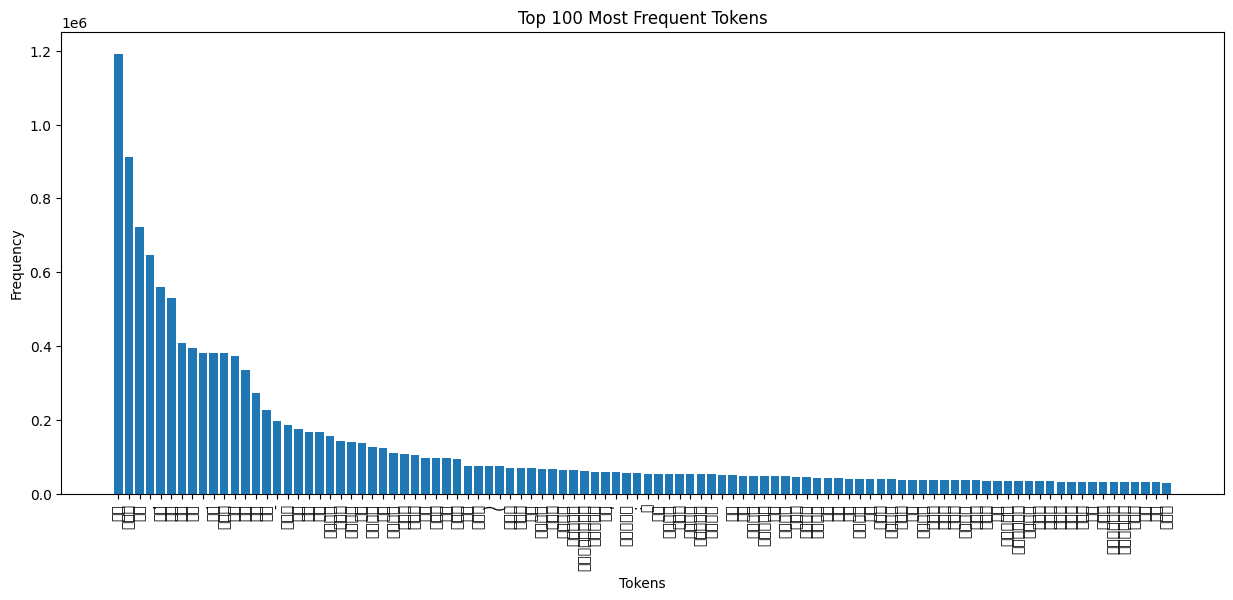

C:\Users\91630\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2338 (\N{DEVANAGARI LETTER DDHA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\91630\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2364 (\N{DEVANAGARI SIGN NUKTA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\91630\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2335 (\N{DEVANAGARI LETTER TTA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\91630\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2337 (\N{DEVANAGARI LETTER DDA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\91630\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyp

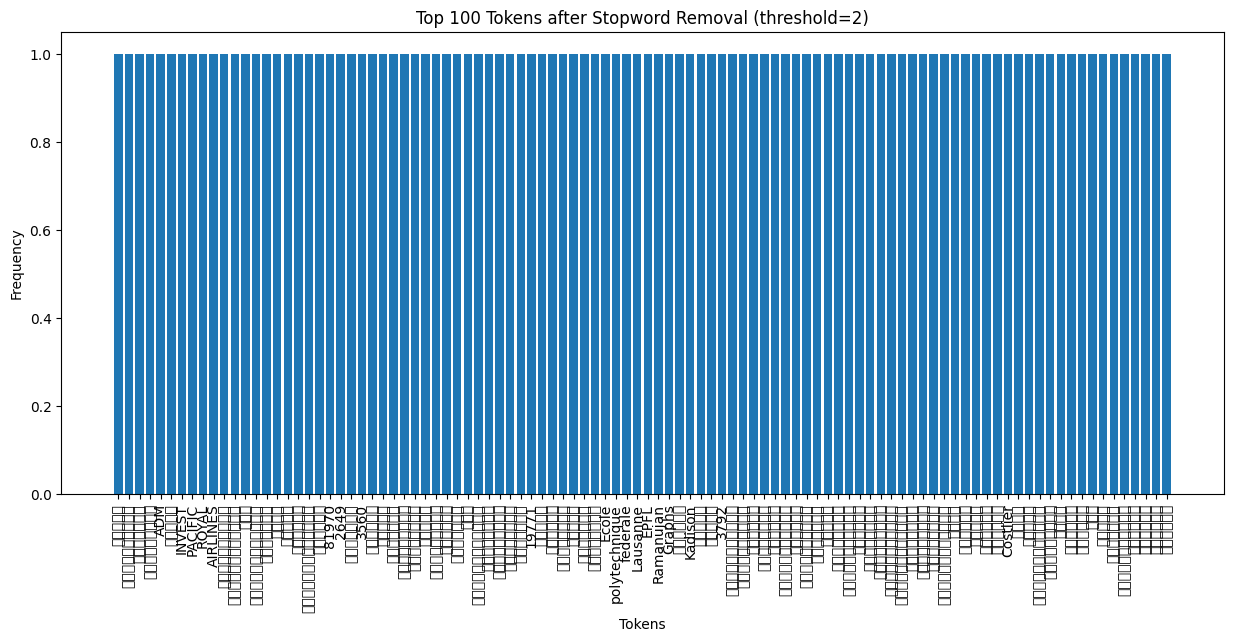

C:\Users\91630\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2396 (\N{DEVANAGARI LETTER DDDHA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\91630\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2305 (\N{DEVANAGARI SIGN CANDRABINDU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\91630\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2307 (\N{DEVANAGARI SIGN VISARGA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\91630\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2336 (\N{DEVANAGARI LETTER TTHA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


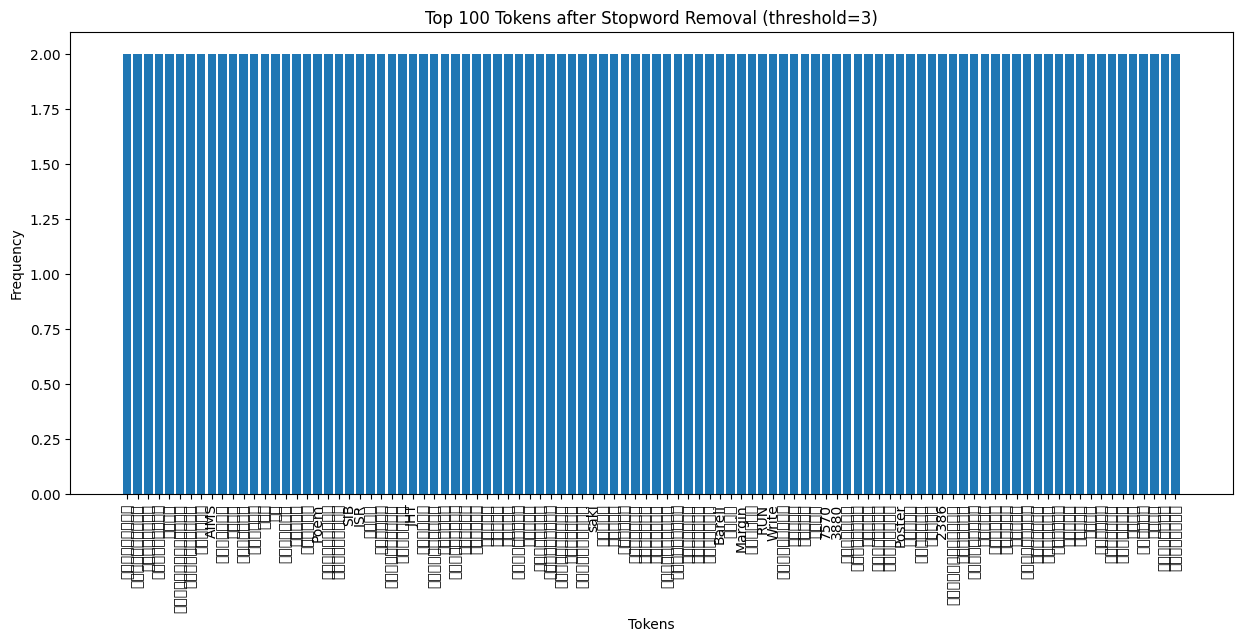

In [14]:
import matplotlib.pyplot as plt 

text = " ".join(sample["text"] for sample in samples)
tokens = hindi_tokenizer(text)

# ---------- STEP 2: FREQUENCY DISTRIBUTION ----------
freq_dist = {}
for token in tokens:
    freq_dist[token] = freq_dist.get(token, 0) + 1

sorted_freq = sorted(freq_dist.items(), key=lambda x: x[1], reverse=True)
top_100 = sorted_freq[:100]

words, counts = zip(*top_100)

plt.figure(figsize=(15, 6))
plt.bar(words, counts)
plt.xticks(rotation=90)
plt.title("Top 100 Most Frequent Tokens")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.show()

# ---------- STEP 4: REMOVE STOPWORDS BASED ON FREQUENCY ----------
def remove_stopwords(freq_dist, threshold):
    """Remove tokens with frequency >= threshold"""
    return {word: freq for word, freq in freq_dist.items() if freq < threshold}

# ---------- STEP 5: PLOT AFTER REMOVAL FOR THREE THRESHOLDS ----------
thresholds = [2, 3, 5]   # You can adjust

for t in thresholds:
    filtered_freq = remove_stopwords(freq_dist, t)
    sorted_filtered = sorted(filtered_freq.items(), key=lambda x: x[1], reverse=True)[:100]

    if not sorted_filtered:
        continue

    words, counts = zip(*sorted_filtered)

    plt.figure(figsize=(15, 6))
    plt.bar(words, counts)
    plt.xticks(rotation=90)
    plt.title(f"Top 100 Tokens after Stopword Removal (threshold={t})")
    plt.xlabel("Tokens")
    plt.ylabel("Frequency")
    plt.show()    

In [10]:
import re

def english_tokenizer(text):
    # Define patterns
    url_pattern = r'https?://[^\s]+|www\.[^\s]+'
    email_pattern = r'\b[\w\.-]+@[\w\.-]+\.\w{2,}\b'

    # Save and replace URLs/emails
    urls = re.findall(url_pattern, text)
    text = re.sub(url_pattern, '<URL>', text)

    emails = re.findall(email_pattern, text)
    text = re.sub(email_pattern, '<EMAIL>', text)

    tokens = []
    for token in text.split():
        if token == '<URL>':
            tokens.append(urls.pop(0))
        elif token == '<EMAIL>':
            tokens.append(emails.pop(0))
        else:
            # Tokenize: words, numbers, punctuation
            split_tokens = re.findall(r"[a-zA-Z0-9]+|[.,!?;:'\"()\-]|[^\s]", token)
            tokens.extend(split_tokens)

    return tokens

def english_sentence_tokenizer(text):
    # Split on sentence-ending punctuation followed by space
    sentence_end_pattern = r'(?<=[.!?])\s+'
    sentences = re.split(sentence_end_pattern, text.strip())
    return [s.strip() for s in sentences if s.strip()]

def detokenize(tokens):
    sentence = ''
    for i, token in enumerate(tokens):
        if i > 0 and not re.match(r'[.,!?;:)\]\'\"]', token):
            sentence += ' '
        sentence += token
    return sentence.strip()

def english_corpus_statistics(text):
    sentences = english_sentence_tokenizer(text)
    all_tokens = []
    reconstructed_sentences = []

    for sentence in sentences:
        tokens = english_tokenizer(sentence)
        all_tokens.extend(tokens)

        reconstructed = detokenize(tokens)
        reconstructed_sentences.append(reconstructed)

    num_tokens = len(all_tokens)
    unique_tokens = set(all_tokens)
    total_chars = sum(len(token) for token in all_tokens)

    word_tokens = [t for t in all_tokens if re.match(r'^[a-zA-Z0-9]+$', t)]
    avg_word_length = sum(len(t) for t in word_tokens) / len(word_tokens) if word_tokens else 0
    type_token_ratio = len(unique_tokens) / num_tokens if num_tokens else 0

    return {
        'sentences': sentences,
        'tokens': all_tokens,
        'num_tokens': num_tokens,
        'total_characters': total_chars,
        'average_word_length': round(avg_word_length, 2),
        'type_token_ratio': round(type_token_ratio, 3),
        'reconstructed_sentences': reconstructed_sentences
    }


In [11]:
text = """Hi! My name is John. Email me at john.doe@example.com or visit https://openai.com. 
This is amazing, isn't it? Let's test URLs like www.testsite.com too."""

stats = english_corpus_statistics(text)

print("Original Sentences:")
for s in stats['sentences']:
    print(s)

print("\nReconstructed Sentences:")
for s in stats['reconstructed_sentences']:
    print(s)

print("\nTokens:", stats['tokens'])
print("Number of Tokens:", stats['num_tokens'])
print("Total Characters:", stats['total_characters'])
print("Average Word Length:", stats['average_word_length'])
print("Type-Token Ratio:", stats['type_token_ratio'])


Original Sentences:
Hi!
My name is John.
Email me at john.doe@example.com or visit https://openai.com.
This is amazing, isn't it?
Let's test URLs like www.testsite.com too.

Reconstructed Sentences:
Hi!
My name is John.
Email me at john.doe@example.com or visit https://openai.com.
This is amazing, isn' t it?
Let' s test URLs like www.testsite.com too.

Tokens: ['Hi', '!', 'My', 'name', 'is', 'John', '.', 'Email', 'me', 'at', 'john.doe@example.com', 'or', 'visit', 'https://openai.com.', 'This', 'is', 'amazing', ',', 'isn', "'", 't', 'it', '?', 'Let', "'", 's', 'test', 'URLs', 'like', 'www.testsite.com', 'too', '.']
Number of Tokens: 32
Total Characters: 130
Average Word Length: 3.09
Type-Token Ratio: 0.906
